<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the Fokker-Planck equation derived in *Craske J. et al. 2024* to the case of 1D scalar diffusion on a bounded domain. The diffusion equation is solved using the open source pseudo-spectral code [Dedalus](https://dedalus-project.org/) (*Burns K.J. et. al. 2020*), while the relevant terms in the Fokker-Planck equation are estimated using histograms.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()


**Content**

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)


Next we write a solver for the equation for the scalar concentration
\begin{equation}
\partial_t C = \kappa \partial_z^2 C, \quad z \in [0,1],
\end{equation}
over the time interval $t \in [0,.25/\kappa]$ subject to the boundary conditions
\begin{aligned}
 \Gamma C - \beta \partial_z C &= g_0(t), \quad \text{at} \quad z = 0, \\
 \Gamma C + \beta \partial_z C &= g_1(t), \quad \text{at} \quad z = 1.
\end{aligned}
As an initial condition we choose
\begin{equation}
C(z,t=0) = \sin(2 \pi z).
\end{equation}
*The functions $g_0(t),g_1(t)$ can be modified below*

In [104]:
# Boundary conditions
def g_0(t):
    return -1;
def g_1(t):
    return  1;

# Solver
def Solve(β, Γ, κ, Nz=512):

  stop_sim_time = .125*(1/κ) # Less than a diffusion time so not a steady state solution
  timestep      = 1e-04

  zcoord = d3.Coordinate('z')
  dist   = d3.Distributor(zcoord, dtype=np.float64)
  zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

  # Fields
  C      = dist.Field(name='c', bases=zbasis)
  tau_c1 = dist.Field(name='tau_c1')
  tau_c2 = dist.Field(name='tau_c2')
  g0     = dist.Field(name='g0')
  g1     = dist.Field(name='g1')

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)
  Cz = dz(C)  + lift(tau_c1)
  Czz= dz(Cz) + lift(tau_c2)

  # Problem
  problem = d3.IVP([C, tau_c1, tau_c2], namespace=locals())
  problem.add_equation("dt(C) - κ*Czz = 0")
  problem.add_equation("Γ*C(z=0) - β*dz(C)(z=0) = g0")
  problem.add_equation("Γ*C(z=1) + β*dz(C)(z=1) = g1")

  # Solver
  solver = problem.build_solver(d3.RK222)
  solver.stop_sim_time = stop_sim_time

  # Initial condition
  z      = dist.local_grid(zbasis)
  if β == 0:
    C['g'] = - 1 + 2*z    + np.sin(2.*np.pi*z)
  elif Γ == 0:
    C['g'] = - z +   z**2 + np.cos(2.*np.pi*z)
  else:
    C['g'] = - 1 + 2*z    + np.sin(2.*np.pi*z)

  # Flow properties
  flow = d3.GlobalFlowProperty(solver, cadence=500)
  flow.add_property(d3.Integrate(C**2) , name='<C^2>')
  flow.add_property(d3.Integrate(Cz**2), name='<Cz^2>')

  # Main loop
  logger.info('Starting main loop')
  while solver.proceed:

      # Specify the bcs
      g0['g'] = g_0(solver.sim_time)
      g1['g'] = g_1(solver.sim_time)

      solver.step(timestep)
      if (solver.iteration-1) % int(stop_sim_time/(4.*timestep)) == 0:

          C2_avg  = flow.grid_average('<C^2>')
          Cz2_avg = flow.grid_average('<Cz^2>')

          # logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
          # logger.info('<C^2>=%f, <Cz^2>    =%f'%(C2_avg,Cz2_avg))

      # Capture the last 5 snapshots
      if  solver.iteration == int(stop_sim_time/timestep) - 5:
          snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
          snapshots.add_task(C , layout='g',name='C' ,scales=3/2)
          snapshots.add_task(Cz, layout='g',name='Cz',scales=3/2)

  return None

The Fokker-Planck equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f = -\frac{\partial}{ \partial c} \left( \mathbb{D}^{(1)} f \right) + \frac{\partial^2 }{ \partial c^2} \left( \mathbb{D}^{(2)} f \right),
\end{equation}
where
\begin{equation}
\mathbb{D}^{(1)} = \mathbb{E}_{C_t}[\kappa \left( \boldsymbol{n} \cdot \nabla C_t \right)] \frac{h}{f}, \quad\quad \mathbb{D}^{(2)} = \mathbb{E}_{C_t}[-\kappa |\nabla C|^2],
\end{equation}
$h(c;t)$ corresponds to the (unnormalised) density when $C_t$ is sampled from the boundary of the domain and $f(c;t)$ is the global probability density function. This density describes the probability of finding a scalar concentration $c$ at a time $t$ in the interval $z \in [0,1]$. Having time integrated the transport equation for the solute concentration we have a set of snapshots $C(z,t)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we now use this data to calculate the terms in this equation.
<!-- \begin{equation}
\partial_tf_C = \int_0^1  \kappa \partial^2_z f_{C|Z} dz - \kappa \partial^2_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right).
\end{equation} -->

In [102]:
def Data(N_bins=128):

  # Data loading
  file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

  # Interpolate the data (t,z) from a Chebyshev grid onto a uniform grid
  C_cheb  = file['tasks/C' ][:,:]
  Cz_cheb = file['tasks/Cz'][:,:]
  z_cheb  = file['tasks/C'].dims[1][0][:]
  times   = file['tasks/C'].dims[0][0][:]

  dz_cheb = z_cheb[1]-z_cheb[0];
  z_data  = np.arange(0,1,dz_cheb);
  s       = (len(times),len(z_data));
  C_data  = np.zeros(s)
  Cz_data = np.zeros(s)
  for i,t in enumerate(times):
    C_data[i,:] = np.interp(z_data, z_cheb, C_cheb[i,:] )
    Cz_data[i,:]= np.interp(z_data, z_cheb, Cz_cheb[i,:])
  dC2_data = Cz_data**2;

  return times, z_data,C_data,Cz_data,dC2_data;

*Time derivative*

To evaluate the left hand side we estimate the pdf $f$ (using a histogram) and then compute its time derivative $\partial_t f$ using central differences.

In [5]:
def dfdt(times,C_data,N_bins=128):

  # PDF f_C
  f_np2,c = np.histogram(C_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
  f_np1,c = np.histogram(C_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

  f_nm1,c = np.histogram(C_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
  f_nm2,c = np.histogram(C_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

  c       = 0.5*(c[1:] + c[:-1]); dc = c[1] - c[0];

  # Time derivate df_C/dt
  dt   = times[-1] - times[-2];
  #dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
  dfdt =                    (1./2.)*f_np1 - (1./2.)*f_nm1
  dfdt /=dt;

  return dfdt;

*Diffusion Coefficient*

For the right hand side we first compute the diffusion coefficient
\begin{equation}
\mathbb{D}^{(2)} \equiv \mathbb{E}_{C_t}[-\kappa |\nabla C_t|^2] = \int \phi \frac{ f(\phi,c,t) }{f(c,t)} d \phi, \quad \text{where} \quad \phi = |\nabla C_t|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram. Subsequently we create the derivative operator $L = \partial^2_s$ using central differences. Having used central differencing to estimate the time derivative centered at time index n=-3 we must evaluate this conditional expectation at the same index.

In [20]:
def diffusion(dC2_data,C_data,N_bins=128):

  # Expectation
  # Let Φ = |∇C|^2 and φ its dummy variable
  f_CΦ,c,φ = np.histogram2d(C_data[-3,...].flatten(), dC2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  c = .5*(c[1:]+c[:-1]); dc = c[1] - c[0];
  f_C =  np.sum(  f_CΦ,axis=1)*dφ;      # f_C(c)
  E   = (np.sum(φ*f_CΦ,axis=1)*dφ)/f_C; # E{Φ|C} = int_φ f_Φ|C(φ|c)*φ dφ

  return E,f_C,c

def Laplacian(c):

  N = len(c)
  dc= c[1]-c[0]
  L = np.zeros((N,N))
  for i in range(N):

    if i == 0:
        L[i,i  ] = -2.
        L[i,i+1] =  1
    elif i == N-1:
        L[i,i-1] =  1.
        L[i,i  ] = -2
    else:
        L[i,i-1] =  1
        L[i,i  ] = -2.
        L[i,i+1] =  1

  L   *= 1./(dc**2);
  return L;

*Drift coefficient*

The drift coefficient for this one dimensional case reduces to
\begin{equation}
\mathbb{D}^{(1)} = \frac{\kappa}{f} \Bigl( \mathbb{E}_{C_t}[ \partial_z C_t|_{z=1}] h(c|z=1,t) - \mathbb{E}_{C_t}[\partial_z C_t|_{z=0} ]h(c|z=0,t) \Bigr)
\end{equation}
where the (unnormalised) density $h$ when $C_t$ is sampled from the boundary is given by
\begin{equation}
h(c|z=1,t) = \delta(c - C_t(z=1)), \quad h(c|z=0,t) = \delta(c - C_t(z=0)).
\end{equation}
This follows from the fact that at the end points of our domain which is an interval $C_t$ can take one value only.

*Dirichlet $\beta = 0$* For this case we know $C_t$ on the boundaries and thus $h$. However as we do not know $\partial_z C_t$ calculating $\mathbb{D}^{(1)}$ reduces to evaluating
\begin{equation}
\mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=1}] = \mathbb{E} \left[ \partial_z C_t  \middle| C_t = g_1/\Gamma,Z=1 \right], \quad\quad \mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=0}] = \mathbb{E} \left[ \partial_z C_t  \middle| C_t = g_0/\Gamma,Z=0 \right],
\end{equation}
or more simply $\partial_z C_t$ on the boundaries.

*Neumann $\Gamma \neq 0$* For this case we know that at the boundaries
\begin{equation}
\mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=1}] = \frac{g_1 - \Gamma c}{\beta}, \quad \mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=0}] = -\frac{g_0 - \Gamma c}{\beta},
\end{equation}
but we do not know $C_t$. As such the task of calculating $D^{(1)}$ reduces to calcultaing the conditional pdf $h$ on the boundaries.

In [33]:
def drift(f_c,c,κ,β,Γ):

  file    = h5py.File('snapshots/snapshots_s1.h5', mode='r')
  C_cheb  = file['tasks/C' ][:,:]
  Cz_cheb = file['tasks/Cz'][:,:]

  int_D1f_C    = 0.*c
  if β == 0:
    int_D1f_C[:] =-Cz_cheb[-3,  0] # C(z=0)
  else:
    int_D1f_C[:] = (g_0(times[-3]) - Γ*C_cheb[-3, 0])/β

  return κ*int_D1f_C

**Results**

Having computed the terms appearing in the left and right hand sides of the Fokker-Planck for this advection diffusion problem we now investigate their form as well as validating that the left and right hand sides are equal. The figure below plots (a) the scalar field $C(z,t_n)$, (b) the density and the diffusion coefficient $f, \mathbb{D}^{(2)}$ and (c) the right and left hand sides of the Fokker-Planck equation.


To avoid artificially smoothing the data in frame (c) we twice integrate the Fokker-Planck equation with respect to $c$ when comparing the left and right hand side. In particular we treat the drift term analytically using the fact that the fact that
\begin{equation}
\int \mathbb{E}[\phi|C_t = c]h dc  = \int \mathbb{E}[\phi|C_t = c]\delta(c - a) dc =  \mathbb{E}[\phi|C_t = a]H(c - a) + c_1,
\end{equation}
where $H(x)$ denotes the heavisde step function and $c_1$ is a constant.

In [84]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

def Plot_Terms(z_data,C_data,c,f_C,E,LHS,RHS):

  fig, axs = plt.subplots(1,3,figsize=(12,6))

  axs[0].plot(z_data,C_data[-1,:],'k')
  axs[0].set_xlim([0,1])
  axs[0].set_ylabel(r'$C(z,t_n)$',fontsize=20)
  axs[0].set_xlabel(r'$z$',fontsize=20)

  axs[1].plot(c,f_C,'r', linewidth=2,label=r'$f(c,t_n)$')
  axs[1].fill_between(x=c,y1=f_C,color= "r",alpha= 0.2)
  axs[1].plot(c,E  ,'b', linewidth=2,label=r'$\mathbb{E}_{C_t}[|\nabla C_t|^2]$')
  axs[1].set_xlabel(r'$c$',fontsize=24)
  axs[1].set_xlim([np.min(c),np.max(c)])
  axs[1].set_ylim([0.,1.1*np.max(f_C)])
  axs[1].legend(loc=8,fontsize=20)

  axs[2].plot(c,LHS,'r-',label=r'$\int \int ( \partial_t f) dcdc$')
  axs[2].plot(c,RHS,'b-',label=r'$-\int ( \mathbb{D}^{(1)} f ) dc + D^{(2)} f $')
  axs[2].set_xlabel(r'$c$',fontsize=24)
  axs[2].set_xlim([np.min(c),np.max(c)])
  #axs[2].set_ylim([np.min(LHS),1.1*np.max(LHS)])
  axs[2].legend(loc=8,fontsize=16)

  for n,ax in enumerate(axs):
      ax.tick_params(axis='x', labelsize=20)
      ax.tick_params(axis='y', labelsize=20)

  plt.tight_layout()
  plt.savefig('1D_Diffusion.png',dpi=200)
  plt.show()

  return None;

*Dirichelt Validation $\beta=0$*

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


2024-04-18 16:40:57,460 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


INFO:__main__:Starting main loop


2024-04-18 16:40:57,467 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-04-18 16:41:02,255 solvers 0/1 INFO :: Simulation stop time reached.


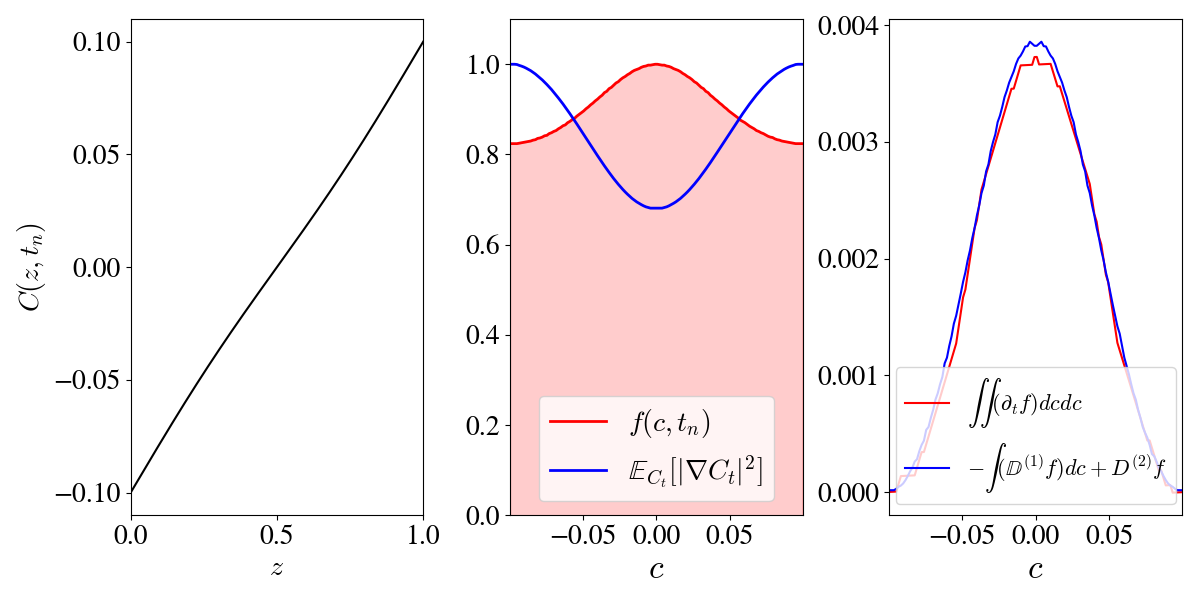

In [111]:
# Parameters
κ = 0.1;
β = 0.0;
Γ = 5.0;

# Solve & grab the data
Solve(β, Γ, κ, Nz=512)
times, z_data,C_data,Cz_data,dC2_data = Data()

# Estimate the terms
df_cdt    = dfdt(times   ,C_data)
E,f_C,c   = diffusion(dC2_data,C_data)
D2        = -κ*E
int_D1f_C = drift(f_C,c,κ,β,Γ)

L   = Laplacian(c);
LHS = np.linalg.solve(L,df_cdt)
RHS = -int_D1f_C + D2*f_C

# Before plotting we normalise f_C,E for visualisation
f_C /=np.max(f_C)
E   /=np.max(E)
Plot_Terms(z_data,C_data,c,f_C,E,LHS,RHS)

*Neumann Validation $\Gamma = 0$*

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-04-18 16:41:47,993 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:__main__:Starting main loop


2024-04-18 16:41:48,000 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-04-18 16:41:58,731 solvers 0/1 INFO :: Simulation stop time reached.


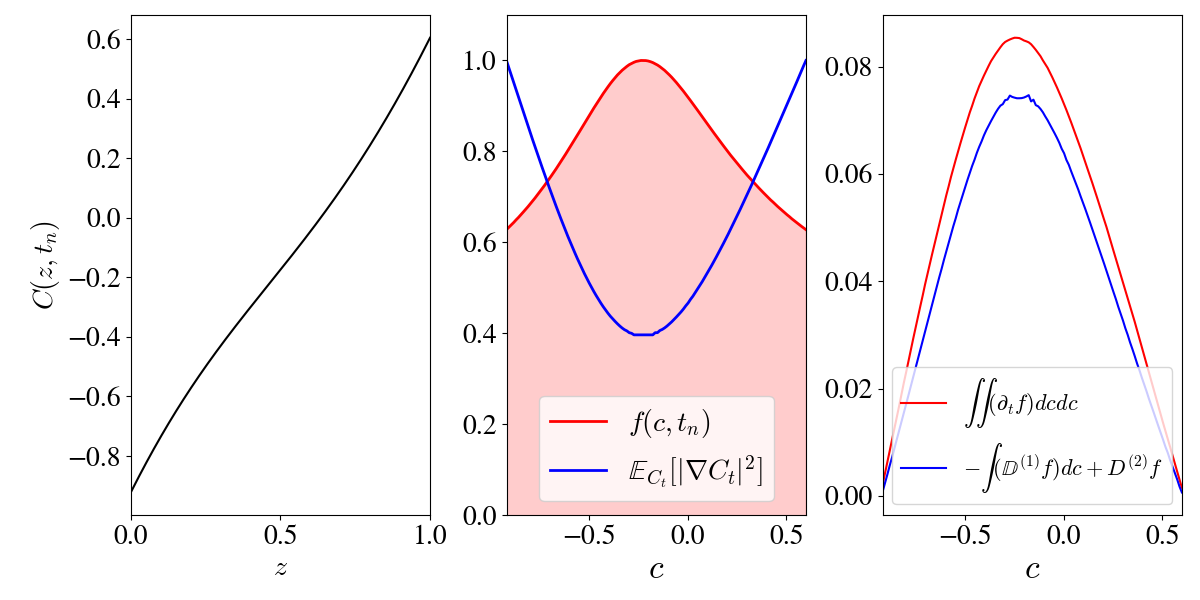

In [114]:
# Parameters
β = 0.5;
Γ = 0.0;
κ = 0.1;

# Solve & grab the data
Solve(β, Γ, κ, Nz=1024)
times, z_data,C_data,Cz_data,dC2_data = Data()

# Estimate the terms
df_cdt    = dfdt(times   ,C_data)
E,f_C,c   = diffusion(dC2_data,C_data)
D2        = -κ*E
int_D1f_C = drift(f_C,c,κ,β,Γ)

L   = Laplacian(c);
LHS = np.linalg.solve(L,df_cdt)
RHS = -int_D1f_C + D2*f_C

# Before plotting we normalise f_C,E for visualisation
f_C /=np.max(f_C)
E   /=np.max(E)
Plot_Terms(z_data,C_data,c,f_C,E,LHS,RHS)